In [28]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np 
import matplotlib.pyplot as plt

In [29]:
def system_dynamics(x_t, u_t):
    """
    System dynamics: x_t+1 = x_t + 0.5*u_t
    """
    return x_t + 0.5 * u_t

def analytical_controller(x_t):
    """
    Analytical control law to make x_t+1 = 0
    """
    return -2 * x_t

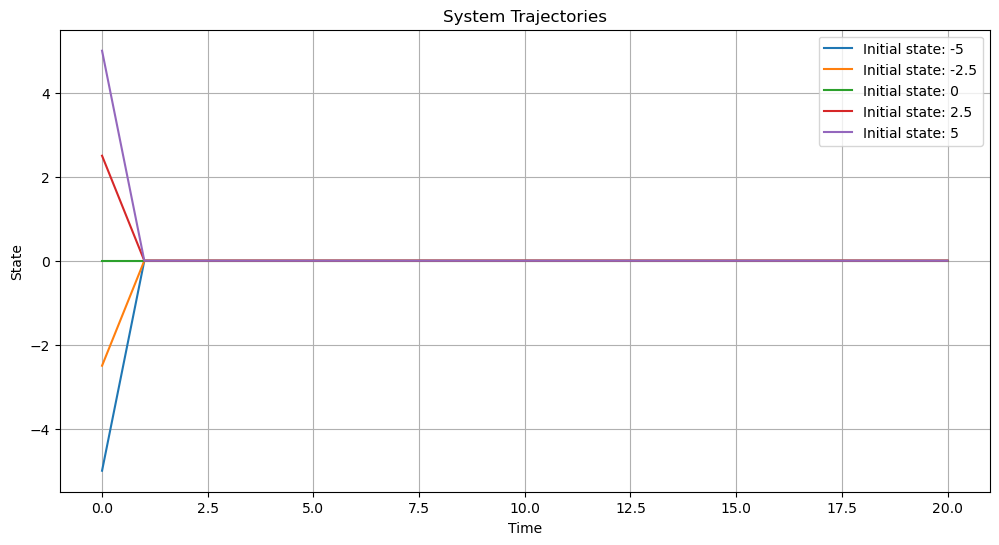

In [30]:
# Data
n_steps = 20
x0_vals = [-5, -2.5, 0, 2.5, 5]
np.array(x0_vals)
time_steps = np.arange(n_steps + 1)

x_history = np.zeros((len(x0_vals), n_steps + 1))
u_history = np.zeros((len(x0_vals), n_steps))

for i, x0 in enumerate(x0_vals):
    x_history[i, 0] = x0
    for t in range(n_steps):
        u_t = analytical_controller(x_history[i, t])
        x_history[i, t + 1] = system_dynamics(x_history[i, t], u_t)
        u_history[i, t] = u_t

plt.figure(figsize=(12, 6))
for i in range(len(x0_vals)):
    plt.plot(time_steps, x_history[i], label=f'Initial state: {x0_vals[i]}')
plt.xlabel('Time')
plt.ylabel('State')
plt.title('System Trajectories')
plt.grid(True)
plt.legend()
plt.show()

In [31]:
# Generate training data
x_data = np.random.uniform(-10, 10, (1000,1))
u_data = analytical_controller(x_data)  # Generate corresponding control inputs

x_train, x_test, u_train, u_test = train_test_split(
    x_data, 
    u_data.reshape(-1, 1), 
    test_size=0.2, 
    random_state=42
)
inputs = Input(shape=(1,))
dense = Dense(64, activation='relu')(inputs)
dense = Dense(64, activation='relu')(dense)
outputs = Dense(1, activation='linear')(dense)

In [32]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')
model.fit(x_train, u_train, epochs=100, batch_size=32, validation_split=0.2)
predictions = model.predict(x_test)
r2 = r2_score(u_test, predictions)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 98.4304 - val_loss: 58.7420
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46.9594 - val_loss: 19.5429
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.4609 - val_loss: 1.2496
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4549 - val_loss: 0.0838
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0814 - val_loss: 0.0726
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0667 - val_loss: 0.0659
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0556 - val_loss: 0.0606
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0472 - val_loss: 0.0517
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0511 - val_loss: 0.0449
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0414 - val_loss: 0.0422
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0358 - val_loss: 0.0342
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

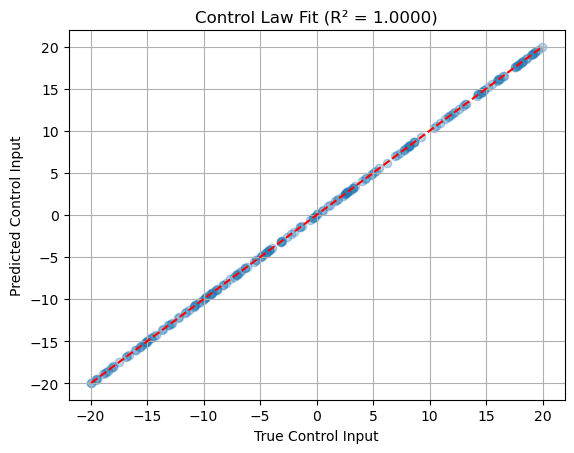

In [33]:
plt.scatter(u_test, predictions, alpha=0.3)
plt.plot([u_test.min(), u_test.max()], [u_test.min(), u_test.max()], 'r--')
plt.xlabel('True Control Input')
plt.ylabel('Predicted Control Input')
plt.title(f'Control Law Fit (R² = {r2:.4f})')
plt.grid()

plt.show()

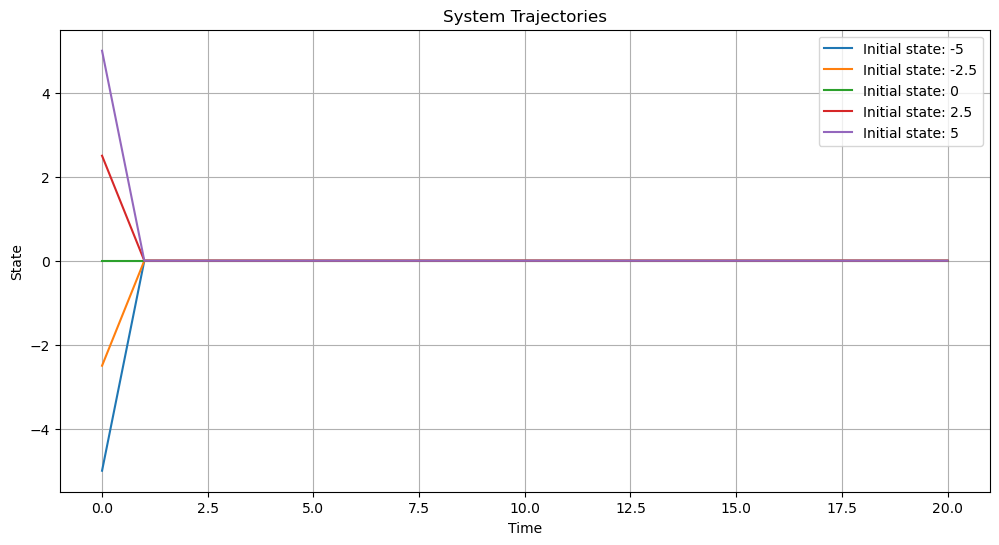

In [34]:
# Data
n_steps = 20
x0_vals = [-5, -2.5, 0, 2.5, 5]
np.array(x0_vals)
time_steps = np.arange(n_steps + 1)

x_history = np.zeros((len(x0_vals), n_steps + 1))
u_history = np.zeros((len(x0_vals), n_steps))

for i, x0 in enumerate(x0_vals):
    x_history[i, 0] = x0
    for t in range(n_steps):
        u_t = analytical_controller(x_history[i, t])
        x_history[i, t + 1] = system_dynamics(x_history[i, t], u_t)
        u_history[i, t] = u_t

plt.figure(figsize=(12, 6))
for i in range(len(x0_vals)):
    plt.plot(time_steps, x_history[i], label=f'Initial state: {x0_vals[i]}')
plt.xlabel('Time')
plt.ylabel('State')
plt.title('System Trajectories')
plt.grid(True)
plt.legend()
plt.show()

In [35]:
inputs = Input(shape=(1,))
dense = Dense(64, activation='relu')(inputs)
dense = Dense(64, activation='relu')(dense)
outputs = Dense(1, activation='linear')(dense)

controller_model = Model(inputs=inputs, outputs=outputs)
controller_model.compile(optimizer='adam', loss='mse')

In [37]:
epochs = 1000
losses = []

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        total_loss = 0
        current_state = x_history[:, 0].reshape(-1, 1).astype(np.float32)

        for t in range(20):
            u_t = controller_model(current_state)
            next_state = system_dynamics(current_state, u_t)
            total_loss += tf.reduce_mean(next_state**2)  
            current_state = next_state
        
        loss = total_loss / 20  # Average loss over timesteps
    gradients = tape.gradient(loss, controller_model.trainable_variables)
    controller_model.optimizer.apply_gradients(zip(gradients, controller_model.trainable_variables))
    losses.append(float(loss))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

Epoch 10, Loss: 0.5881
Epoch 20, Loss: 0.5262
Epoch 30, Loss: 0.4720
Epoch 40, Loss: 0.4240
Epoch 50, Loss: 0.3820
Epoch 60, Loss: 0.3416
Epoch 70, Loss: 0.3021
Epoch 80, Loss: 0.2649
Epoch 90, Loss: 0.2309
Epoch 100, Loss: 0.2005
Epoch 110, Loss: 0.1737
Epoch 120, Loss: 0.1501
Epoch 130, Loss: 0.1296
Epoch 140, Loss: 0.1118
Epoch 150, Loss: 0.0965
Epoch 160, Loss: 0.0831
Epoch 170, Loss: 0.0716
Epoch 180, Loss: 0.0615
Epoch 190, Loss: 0.0529
Epoch 200, Loss: 0.0455
Epoch 210, Loss: 0.0390
Epoch 220, Loss: 0.0335
Epoch 230, Loss: 0.0286
Epoch 240, Loss: 0.0244
Epoch 250, Loss: 0.0208
Epoch 260, Loss: 0.0178
Epoch 270, Loss: 0.0151
Epoch 280, Loss: 0.0128
Epoch 290, Loss: 0.0108
Epoch 300, Loss: 0.0091
Epoch 310, Loss: 0.0076
Epoch 320, Loss: 0.0063
Epoch 330, Loss: 0.0053
Epoch 340, Loss: 0.0043
Epoch 350, Loss: 0.0036
Epoch 360, Loss: 0.0030
Epoch 370, Loss: 0.0025
Epoch 380, Loss: 0.0021
Epoch 390, Loss: 0.0018
Epoch 400, Loss: 0.0015
Epoch 410, Loss: 0.0013
Epoch 420, Loss: 0.0010
E

In [38]:
x_test = np.linspace(-10, 10, 100).reshape(-1, 1)
u_pred = controller_model.predict(x_test[:, 0].reshape(-1, 1).astype(np.float32))
r2 = r2_score(analytical_controller(x_test), u_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


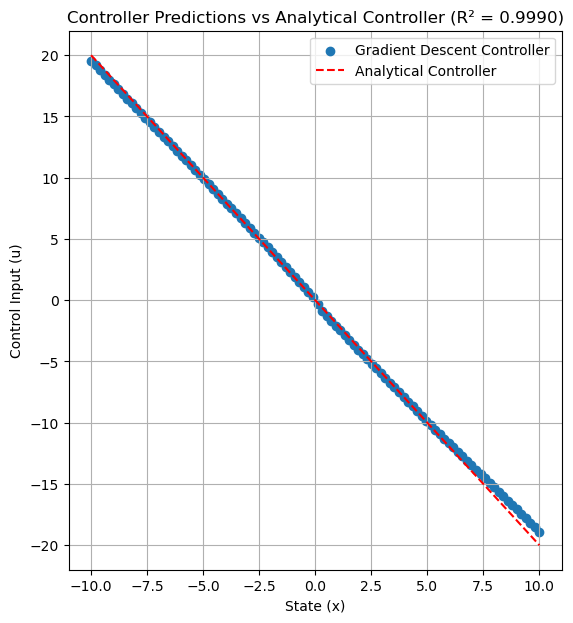

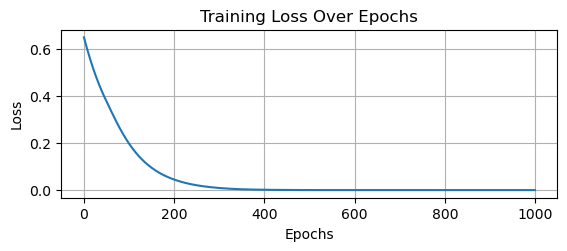

In [44]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.scatter(x_test, u_pred, label= 'Gradient Descent Controller')
plt.plot(x_test, analytical_controller(x_test), 'r--', label='Analytical Controller')
plt.grid()
plt.xlabel('State (x)')
plt.ylabel('Control Input (u)')
plt.title(f'Controller Predictions vs Analytical Controller (R² = {r2:.4f})')
plt.legend()
plt.show()

plt.subplot(2, 1, 1)
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid()
plt.show()